In [82]:
import pandas as pd
import numpy as np
import nltk



import seaborn as sns
import matplotlib.pyplot as plt
import nltk


# # not really using the following ones yet
# from wordcloud import WordCloud
# import fasttext
# import contractions
# import string
# from tqdm.notebook import tqdm

#######needed these ones on the first run####
#nltk.download('punkt') 
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')
#nltk.download('vader_lexicon')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer



from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords, wordnet
# from nltk.stem import WordNetLemmatizer
# from nltk.sentiment import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings("ignore")

# plt.xticks(rotation=70)
# pd.options.mode.chained_assignment = None
# pd.set_option('display.max_colwidth', 100)
# plt.style.use('ggplot')
# %matplotlib inline
# import a lot of libraries that could be used on the project

In [2]:
# recipes = pd.read_csv('foodcom_with_reviews/recipes.csv')
reviews = pd.read_csv('foodcom_with_reviews/reviews.csv')

In [3]:
# recipes.head(1)

In [4]:
type(reviews)

pandas.core.frame.DataFrame

In [5]:
reviews.head(1)

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z


# Cleaning

In [6]:
reviews.isna().sum()

ReviewId           0
RecipeId           0
AuthorId           0
AuthorName         0
Rating             0
Review           214
DateSubmitted      0
DateModified       0
dtype: int64

In [7]:
reviews.loc[reviews['Review'].isna()]

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
165686,177521,121490,125458,eatrealfood,5,NaN,2017-03-24T13:32:48Z,2017-03-24T13:32:48Z
381499,408467,74971,362819,Loryn,4,NaN,2017-02-22T22:22:01Z,2017-02-22T22:22:01Z
511712,555485,22210,362819,Loryn,5,NaN,2017-02-22T22:03:55Z,2017-02-22T22:03:55Z
589730,643706,22274,448426,Kids Stuff,3,NaN,2017-06-09T03:10:30Z,2017-06-09T03:10:30Z
1109687,1270189,359662,547648,leanna.heiman,5,NaN,2017-05-30T05:25:20Z,2017-05-30T05:25:20Z
...,...,...,...,...,...,...,...,...
1378730,2065335,252449,2002310785,Cecily S.,4,NaN,2018-10-24T18:23:15Z,2018-10-24T18:23:15Z
1378916,2065538,122475,2002313998,ayateisheh,5,NaN,2018-10-27T21:58:55Z,2018-10-27T21:58:55Z
1380429,2067166,452478,2002360118,Nancy D.,5,NaN,2018-12-08T19:33:59Z,2018-12-08T19:33:59Z
1385870,2072984,12975,2002375480,Anonymous,5,NaN,2019-06-03T15:26:09Z,2019-06-03T15:26:09Z


In [8]:
type(reviews)

pandas.core.frame.DataFrame

In [9]:
reviews = reviews.dropna()


In [10]:
reviews.isna().sum()

ReviewId         0
RecipeId         0
AuthorId         0
AuthorName       0
Rating           0
Review           0
DateSubmitted    0
DateModified     0
dtype: int64

In [11]:
reviews.duplicated().sum()

0

# EDA

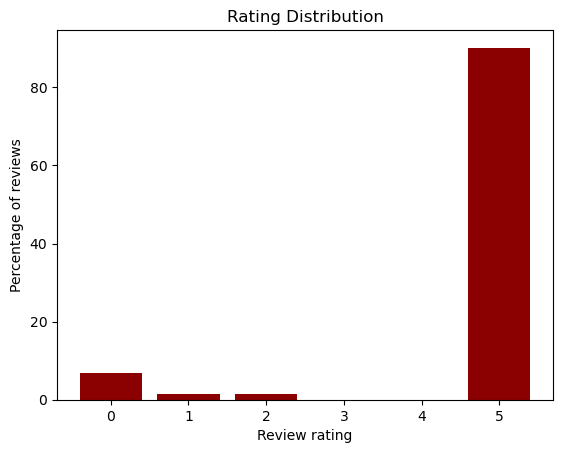

In [56]:
values, counts = np.unique(reviews['Rating'], return_counts = True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(values, normalized_counts * 100, color = 'darkred')
plt.xlabel('Review rating')
plt.ylabel('Percentage of reviews')
plt.title('Rating Distribution')
plt.show()

In [13]:
reviews.shape

(1401768, 8)

In [14]:
# dropping reviews that are 3 or 4
reviews = reviews.drop(reviews[(reviews['Rating'] == 3) | (reviews['Rating'] == 4)].index)

I droped reviews that are 3 and 4 because I want to take only extremes to have a better training on if the word is positive or negative. 3 and 4 could be neutral or mixed review which could confuse my model.

In [15]:
reviews['Sentiment'] = np.where(reviews['Rating'] >=4, 1, 0) 
#later replace with reviews_simple or something like that
reviews.head(3)

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified,Sentiment
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z,1
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z,0
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z,1


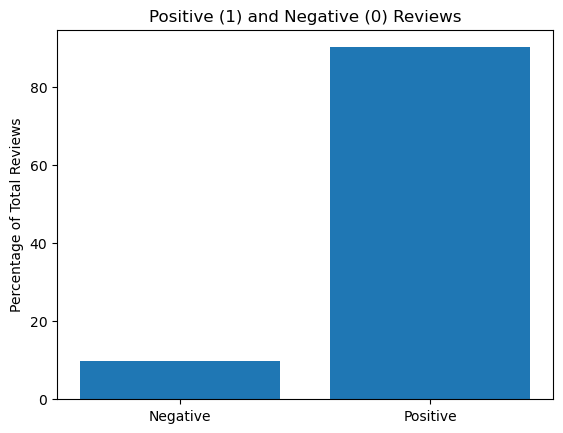

In [16]:
values, counts = np.unique(reviews['Sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(['0','1'], normalized_counts*100)
plt.title('Positive (1) and Negative (0) Reviews')
plt.ylabel('Percentage of Total Reviews')
plt.xticks(ticks = [0,1], labels=['Negative', 'Positive'])
plt.show()

In [17]:
print(values)
print(counts)

[0 1]
[ 110399 1011912]


In [18]:
from sklearn.utils import resample

majority_sentiment = reviews[reviews['Sentiment'] == 1]  # Majority sentiment (positive)
minority_sentiment = reviews[reviews['Sentiment'] == 0]  # Minority sentiment (negative)

# Upsample the minority sentiment
oversampled_minority = resample(minority_sentiment,
                                replace=True,  # Allow duplication
                                n_samples=len(majority_sentiment),  # Match majority sentiment size
                                random_state=42)  # Set a random seed for reproducibility

# Combine the majority sentiment with the oversampled minority sentiment
balanced_reviews = pd.concat([majority_sentiment, oversampled_minority])

# Shuffle the balanced dataset
balanced_reviews = balanced_reviews.sample(frac=1, random_state=42).reset_index(drop=True)

In [19]:
balanced_reviews.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified,Sentiment
0,212628,75103,252556,jtmmmatthews,5,I love this simply yet delicious recipe.\r\n\r...,2005-10-16T14:44:20Z,2005-10-16T14:44:20Z,1
1,484567,254184,356476,Lolas Mama,5,"I'm on a low fat low sodium diet, so it's real...",2007-09-23T17:49:47Z,2007-09-23T17:49:47Z,1
2,1085417,2886,68941,Trickey,0,Thanks for this wonderful recipe. I have made...,2010-04-16T10:55:46Z,2010-04-16T10:55:46Z,0
3,1452481,476676,1803083664,Ryan B.,5,The first time I made his recipe the cookies t...,2014-08-29T18:27:03Z,2014-08-29T18:27:03Z,1
4,2037971,48383,2001793617,Mary L.,0,I did a bone in Turkey for Thanksgiving. I put...,2017-12-06T00:17:17Z,2017-12-06T00:17:17Z,0


In [20]:
# getting rid of the default index and replacing it with review id
balanced_reviews.set_index('ReviewId', inplace=True)
balanced_reviews.head()

,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified,Sentiment
ReviewId,,,,,,,,
212628,75103,252556,jtmmmatthews,5,I love this simply yet delicious recipe.\r\n\r...,2005-10-16T14:44:20Z,2005-10-16T14:44:20Z,1
484567,254184,356476,Lolas Mama,5,"I'm on a low fat low sodium diet, so it's real...",2007-09-23T17:49:47Z,2007-09-23T17:49:47Z,1
1085417,2886,68941,Trickey,0,Thanks for this wonderful recipe. I have made...,2010-04-16T10:55:46Z,2010-04-16T10:55:46Z,0
1452481,476676,1803083664,Ryan B.,5,The first time I made his recipe the cookies t...,2014-08-29T18:27:03Z,2014-08-29T18:27:03Z,1
2037971,48383,2001793617,Mary L.,0,I did a bone in Turkey for Thanksgiving. I put...,2017-12-06T00:17:17Z,2017-12-06T00:17:17Z,0


In [21]:
print(f'Normal reviews: {reviews.shape}')
print(f'balanced reviews: {balanced_reviews.shape}')

Normal reviews: (1122311, 9)
balanced reviews: (2023824, 8)


In [22]:
balanced_reviews['Sentiment'].value_counts()

1    1011912
0    1011912
Name: Sentiment, dtype: int64

In [23]:
sample_size = 50000

# Assuming you have the 'balanced_reviews' DataFrame

# Check if the dataset has more than 50,000 rows
if len(balanced_reviews) > sample_size:
    # Take a random sample of 50,000 rows from the balanced_reviews DataFrame
    sample_reviews = balanced_reviews.sample(n=sample_size, random_state=1)
else:
    # If the dataset has fewer than 50,000 rows, use the entire dataset as the sample
    sample_reviews = balanced_reviews

In [24]:
sample_reviews['Sentiment'].value_counts()

1    25048
0    24952
Name: Sentiment, dtype: int64

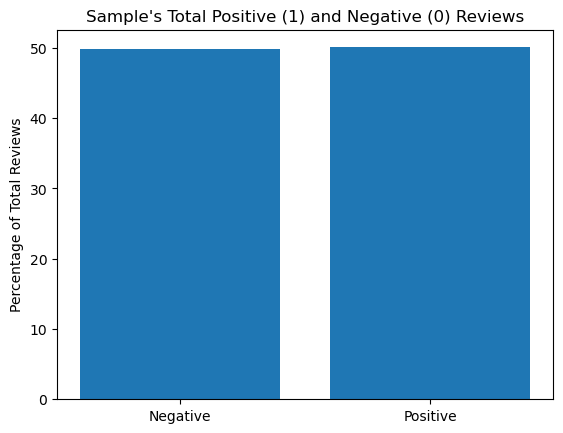

In [25]:
values, counts = np.unique(sample_reviews['Sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(['0','1'], normalized_counts*100)
plt.title("Sample's Total Positive (1) and Negative (0) Reviews")
plt.ylabel('Percentage of Total Reviews')
plt.xticks(ticks = [0,1], labels=['Negative', 'Positive'])
plt.show()

# Start to tokenize

In [26]:
def my_tokenizer(sentence):
    # Instantiate stemmer and stopwords from nltk
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    # Tokenize the sentence into words
    words = word_tokenize(sentence)

    # Making them lower case and remove punctuation
    stemmed_words = [stemmer.stem(word.lower()) for word in words if word.isalpha()]

    # Remove if it is a stop words
    filtered_words = [word for word in stemmed_words if word not in stop_words]

    return filtered_words

In [27]:
# checking my tokenizer
example_sentence = "The quick brown fox, jumped over the lazy dog!!"
my_tokenizer(example_sentence)

['quick', 'brown', 'fox', 'jump', 'lazi', 'dog']

In [28]:
# reviews['Tokenized_Reviews'] = reviews['Review'].apply(my_tokenizer)
# reviews.head(2)

In [29]:
# # I am testing another way of doing sample that is maybe better than this one
# # Convert the values in the 'Review' column to strings
# reviews['Review'] = reviews['Review'].astype(str)


# # Sample a subset of the data
# sample_reviews = reviews.sample(n=50000, random_state=1)




In [30]:
######### took this off for now for testing purposes ############

In [31]:
# # Apply the tokenizer function to the sampled reviews
# tokenized_reviews = sample_reviews['Review'].apply(my_tokenizer)

# sample_reviews['Tokenized_Reviews'] = tokenized_reviews
# sample_reviews['Tokenized_Reviews'].head(3)

In [32]:
# # Separate the data into features (X) and target (y)
# X = reviews.drop('Sentiment', axis=1)
# y = reviews['Sentiment']

# # Taking a chunk for our 20% test set
# X_remainder, X_test, y_remainder, y_test = \
#     train_test_split(X, y, stratify=y, test_size = 0.2,
#                      random_state=1)



In [33]:
# # Splitting the remainder in two chunks
# X_train, X_validation, y_train, y_validation = \
#     train_test_split(X_remainder, y_remainder, test_size = 0.3,
#                      random_state=1)


In [34]:
# X_test.shape #just checking the shape

In [35]:
# X_train.shape

In [36]:


X_sample = sample_reviews['Review'].astype(str)
y_sample = sample_reviews['Sentiment']

# Perform stratified sampling to obtain a balanced sample
X_remainder_sample, X_test_sample, y_remainder_sample, y_test_sample = train_test_split(X_sample, y_sample,  test_size=0.2, stratify=y_sample, random_state=1)

# Splitting the remainder in two chunks
X_train_sample, X_validation_sample, y_train_sample, y_validation_sample = \
    train_test_split(X_remainder_sample, y_remainder_sample, test_size = 0.3,
                     random_state=1)
    

In [37]:
X_train_sample.shape

(28000,)

In [38]:
X_test_sample.shape

(10000,)

In [39]:
# Combine the features and target back into a DataFrame
sampled_reviews = pd.concat([X_remainder_sample, y_remainder_sample], axis=1)
sampled_reviews.head(3)

,Review,Sentiment
ReviewId,,
1109027,Delicious!!! ...and an easy to follow recipe. ...,1
1395449,This actually turned out to be much more cream...,1
472074,This recipe comes from a WW card several years...,1


In [40]:
X_train_sample.head(3)

ReviewId
1382477    They forgot to to mention that when your oven ...
2055925    work in progress, A friend of mine made Seafoo...
2018188    The first time I tried this recipe, it was too...
Name: Review, dtype: object

In [41]:
X_test_sample.head(3)

ReviewId
1129184    This was really good. I added a some leftover ...
1465140    it&#039;s simple and have a good taste.My fami...
1224704    Very good rice dish. I used fresh pineapple, a...
Name: Review, dtype: object

In [42]:
sampled_reviews['Sentiment'].value_counts()
# imbalance on the values

1    20038
0    19962
Name: Sentiment, dtype: int64

In [43]:
# from imblearn.over_sampling import RandomOverSampler
# oversampler = RandomOverSampler(sampling_strategy='auto', random_state=1)

# X_train_sample = X_train_sample.to_numpy().reshape(-1, 1)
# y_train_sample = y_train_sample.to_numpy().reshape(-1, 1)

# X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train_sample, y_train_sample)


In [44]:
# # Convert oversampled data to DataFrames
# X_train_oversampled = pd.DataFrame(X_train_oversampled, columns=['Review'])
# y_train_oversampled = pd.DataFrame(y_train_oversampled, columns=['Sentiment'])

# # Combine the features and target back into a DataFrame
# oversampled_reviews = pd.concat([X_train_oversampled, y_train_oversampled], axis=1)
# oversampled_reviews.head(3)

In [45]:
# oversampled_reviews['Sentiment'].value_counts()

This is a lot more balanced!

In [46]:
# type(X_train_oversampled)

In [47]:
# type(X_train_sample)

In [48]:
# X_train_sample, y_train_sample = oversampler.fit_resample(X_train_sample, y_train_sample)

In [49]:
# type(X_train_sample)

In [50]:
# # Convert oversampled data to DataFrames
# X_train_sample = pd.DataFrame(X_train_sample, columns=['Review'])
# y_train_sample = pd.DataFrame(y_train_sample, columns=['Sentiment'])

# # Combine the features and target back into a DataFrame
# sampled_reviews = pd.concat([X_train_sample, y_train_sample], axis=1)
# sampled_reviews.head(3)

In [51]:
# sampled_reviews['Sentiment'].value_counts()

In [52]:
# print(X_train_sample.dtypes)
# print(y_train_sample.dtypes)

In [53]:
# type(X_train) #I was having problem with the type for some reason
# # solved it by using '.astype(str)'

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer with your tokenizer function
bagofwords = CountVectorizer(min_df=5, tokenizer = my_tokenizer)

# Fit and transform the training data
X_train_sample_transformed = bagofwords.fit_transform(X_train_sample)

# Transform the test data using the fitted CountVectorizer
X_test_sample_transformed = bagofwords.transform(X_test_sample)

# Check the shape of the transformed data
print(X_train_sample_transformed.shape)
print(X_test_sample_transformed.shape)

(28000, 4716)
(10000, 4716)


In [58]:
bagofwords.get_feature_names()

['abandon',
 'abc',
 'abit',
 'abl',
 'abov',
 'absolut',
 'absolutley',
 'absolutli',
 'absorb',
 'abund',
 'accent',
 'accept',
 'access',
 'accid',
 'accident',
 'accommod',
 'accompani',
 'accomplish',
 'accord',
 'accordingli',
 'account',
 'accur',
 'accuraci',
 'accustom',
 'achiev',
 'acid',
 'acorn',
 'across',
 'action',
 'activ',
 'actual',
 'ad',
 'adapt',
 'add',
 'addict',
 'addit',
 'adequ',
 'adher',
 'adjust',
 'admit',
 'admittedli',
 'adob',
 'adobo',
 'adopt',
 'adopte',
 'ador',
 'adult',
 'advanc',
 'advantag',
 'adventur',
 'advers',
 'advic',
 'advis',
 'affect',
 'afford',
 'afraid',
 'africa',
 'african',
 'afternoon',
 'aftertast',
 'afterward',
 'agav',
 'age',
 'agent',
 'agian',
 'ago',
 'agre',
 'ahead',
 'aid',
 'aioli',
 'air',
 'airi',
 'aisl',
 'aka',
 'al',
 'ala',
 'alarm',
 'alcohol',
 'ale',
 'alfredo',
 'alic',
 'alik',
 'alittl',
 'aliv',
 'allerg',
 'allergi',
 'alley',
 'allow',
 'allrecip',
 'allspic',
 'almond',
 'almost',
 'alon',
 'along',

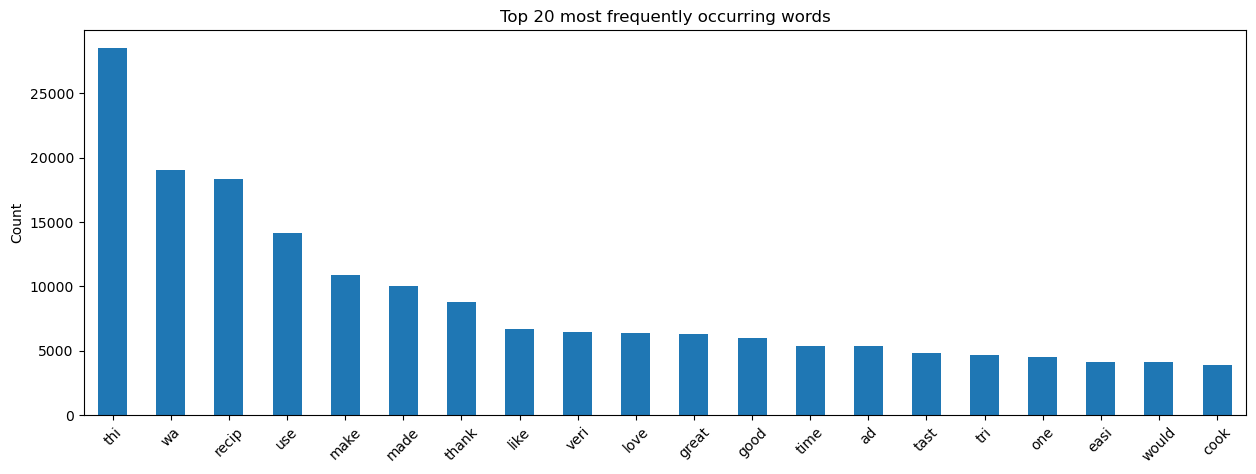

In [60]:
word_counts = pd.DataFrame(
    {"counts": X_train_sample_transformed.toarray().sum(axis=0)},
    index=bagofwords.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [61]:
# Fitting a model
logreg = LogisticRegression(C = 0.1)
logreg.fit(X_train_sample_transformed, y_train_sample)

# Training and test score
print(f"Train score: {logreg.score(X_train_sample_transformed, y_train_sample)}")
print(f"Test score: {logreg.score(X_test_sample_transformed, y_test_sample)}")

Train score: 0.7960714285714285
Test score: 0.7593


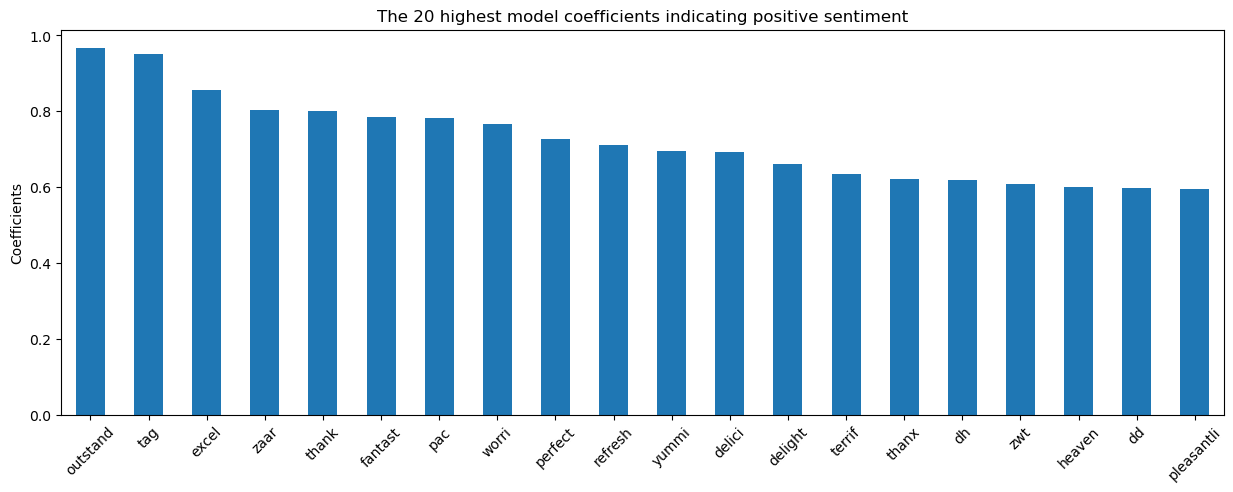

In [63]:
word_counts = pd.DataFrame(
    {"coefficients": logreg.coef_[0]},
    index=bagofwords.get_feature_names()
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

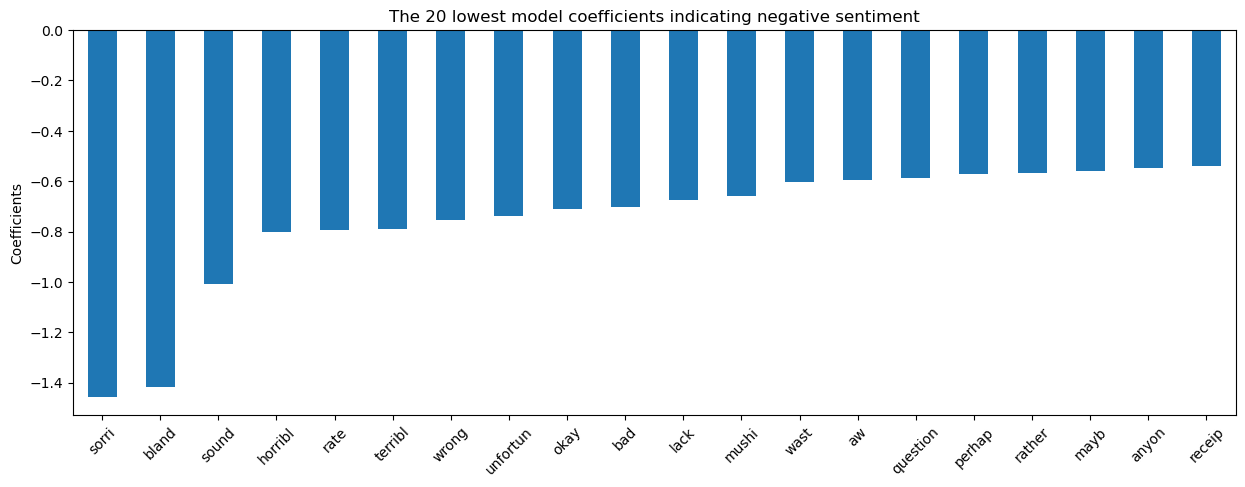

In [64]:
word_counts.sort_values("coefficients", ascending=True).head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 lowest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

In [65]:
print(bagofwords.vocabulary_)
print(bagofwords.get_feature_names())

{'forgot': 1589, 'mention': 2529, 'oven': 2868, 'thi': 4169, 'hot': 1965, 'use': 4418, 'combin': 807, 'ingredi': 2064, 'smoke': 3745, 'fill': 1500, 'hous': 1971, 'work': 4620, 'progress': 3174, 'friend': 1625, 'mine': 2572, 'made': 2419, 'seafood': 3559, 'gumbo': 1825, 'okra': 2807, 'mani': 2442, 'differ': 1136, 'meat': 2504, 'item': 2112, 'hope': 1955, 'turn': 4331, 'correctli': 902, 'edibl': 1285, 'first': 1517, 'time': 4213, 'tri': 4296, 'recip': 3299, 'wa': 4492, 'thin': 4174, 'never': 2716, 'befor': 322, 'thought': 4186, 'suppos': 4037, 'like': 2333, 'put': 3221, 'top': 4253, 'fridg': 1624, 'rise': 3418, 'cold': 795, 'clear': 757, 'pitcher': 3043, 'could': 910, 'see': 3571, 'happen': 1849, 'insid': 2071, 'surpris': 4044, 'kept': 2192, 'separ': 3590, 'sometim': 3784, 'inch': 2034, 'water': 4519, 'would': 4632, 'sit': 3691, 'stir': 3934, 'back': 252, 'togeth': 4231, 'onli': 2824, 'hour': 1970, 'later': 2264, 'dump': 1251, 'quot': 3245, 'version': 4457, 'talk': 4084, 'night': 2730, '

In [66]:
sample_reviews[sample_reviews['Review'].str.contains('zaar')]

,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified,Sentiment
ReviewId,,,,,,,,
1118827,252161,107135,Dienia B.,5,fast easy cheap tasty served with sarah beths...,2010-06-19T14:18:11Z,2010-06-19T14:18:11Z,1
1267367,139769,2042874,risingsun9365,0,I just finished this recipe and shamelessly sc...,2011-11-21T18:18:42Z,2011-11-21T18:18:42Z,0
873928,181206,137428,ctrmom,0,I am assigning no stars because I have not yet...,2009-05-22T14:04:15Z,2009-05-22T14:04:15Z,0
899197,35813,992009,divertingbailey,5,Such amazing cookies! Even people who aren't h...,2009-07-02T12:30:11Z,2009-07-02T12:30:11Z,1
42088,50080,26584,Vic17460,2,"\r\nAs I looked this recipe over, I wondered h...",2003-02-20T07:19:16Z,2003-02-20T07:19:16Z,0
...,...,...,...,...,...,...,...,...
954408,387934,137302,CarrolJ,5,Wonderful served with salsa! I couldn't belie...,2009-09-24T13:39:06Z,2009-09-24T13:39:06Z,1
833509,349579,58104,Rita1652,0,YUMMO! Comfort food this is!\r\nThere is a lot...,2009-03-23T18:36:34Z,2009-03-23T18:36:34Z,0
480449,84347,487387,Tee Angel,5,It was my turn to bake for the birthday girl a...,2007-09-16T15:48:30Z,2007-09-16T15:48:30Z,1


In [67]:
pd.set_option('display.max_colwidth', None)

In [68]:
sample_reviews[sample_reviews['Review'].str.contains('zaar')]

,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified,Sentiment
ReviewId,,,,,,,,
1118827,252161,107135,Dienia B.,5,fast easy cheap tasty served with sarah beths peas recipe #428882 complete fast cheap meal zaar tour 6,2010-06-19T14:18:11Z,2010-06-19T14:18:11Z,1
1267367,139769,2042874,risingsun9365,0,"I just finished this recipe and shamelessly scraped and licked the spoons. It is amazing. I added 6 oz of chocolate instead of the 3 it calls for. I think that it has a great balance between sweet and chocolate. I am attending a crafters holiday bazaar this weekend, I'm hoping this will make a nice addition to my collection of jams and jellies that I sell. THANK YOU",2011-11-21T18:18:42Z,2011-11-21T18:18:42Z,0
873928,181206,137428,ctrmom,0,"I am assigning no stars because I have not yet made this as written, but this is as close as recipezaar has to the recipe our friends Newell and Karen gave us for Salsa Cruda de Tomatillo, which is 5 star excellent. The only real difference is jalapeno peppers instead of poblanos. Our recipe says 1 lb. tomatillos, 1 onion, 1 clove garlic, 2 jalapenos, 1 small bunch cilantro. I think we used 3/4 t salt. Thanks for posting!",2009-05-22T14:04:15Z,2009-05-22T14:04:15Z,0
899197,35813,992009,divertingbailey,5,Such amazing cookies! Even people who aren't huge fans of oatmeal cookies love these! Best cookie recipe I've gotten off 'zaar yet!,2009-07-02T12:30:11Z,2009-07-02T12:30:11Z,1
42088,50080,26584,Vic17460,2,"\r\nAs I looked this recipe over, I wondered how this would cook slowly for 30 minutes without liquid. Recipezaar Support was helpful, and encouraged me to find an answer and give it a try. I chose vegetable broth at ½ cup per serving. (2½ cups for 6 servings.) This seemed to be about right. I put the broth in after adding the cardamom and nutmeg in step 3. (The recipe calls for garlic twice &#8211; I chose to add it in step 1, and sautéed it with the onion.) Back to step 3, it is hard to brown that much chopped vegetable. The cabbage seems to release liquid, so the process is not real dry. I never got even the potatoes to brown, thought I stirred for over 10 minutes. I choose serranos for the peppers. I served it with injera bread. It is ok, but even with six chopped serranos, it comes across as kind of bland. This could be just because I am missing something about Ethiopian cooking. (More cardamom??) We have some Ethiopian restaurants in the area, and I shall give one a try before going on in an Ethiopian direction. \r\n",2003-02-20T07:19:16Z,2003-02-20T07:19:16Z,0
...,...,...,...,...,...,...,...,...
954408,387934,137302,CarrolJ,5,Wonderful served with salsa! I couldn't believe how much it resembles Chili Rellano in flavor. Surprisingly no one would ever know that there are torn pieces of flour tortillas even in this.I would think if you had any leftover it would be good inserted into a fresh tortilla with salsa and served as a breakfast burrito as well. Very good! Made for PAC Fall 2009.\n\nhttp://www.recipezaar.com/bb/viewtopic.zsp?t=310505&postdays=0&postorder=asc&start=0,2009-09-24T13:39:06Z,2009-09-24T13:39:06Z,1
833509,349579,58104,Rita1652,0,YUMMO! Comfort food this is!\r\nThere is a lot of juice that is released from the cabbage. It would be good to remove the top for half the cooking time. The Worcestershire sauce I added to the meat using only 1 teaspoon. Skipped the salt. used olive oil for sauteing the onions.\r\nMade for PAC http://www.recipezaar.com/bb/viewtopic.zsp?t=296583&postdays=0&postorder=asc&start=0\r\nThanks!,2009-03-23T18:36:34Z,2009-03-23T18:36:34Z,0
480449,84347,487387,Tee Angel,5,It was my turn to bake for the birthday girl at work. She requested 'anything cherry'. I searched through Recipezaar for something quick. This recipe was a huge hit at work! Thank you for posting.,2007-09-16T15:48:30Z,2007-09-16T15:48:30Z,1


I was very curious about certain words such as zaar, dh, zwt, pac, so I made the code above to start diging more into what they mean. I found out the following:
- Zaar: It was the previous name of the website was recipezaar.com and people often reffer to the site as Zaar, many of the comments say they are happy to find a recipe they found before in zaar, others jsut talking about the site (mostly the old comments).
- dh: abbreviation for Dietary history
- zwt: seemed like a random word but it actually is an abbreviation for Zero Waiting Time, makes sense to have it on positive since it means the recipe is very fast to make which makes people have a positive sentiment towards the recipe.
- pac: pace. Some people refer to the apce being fast and easy which is also positive.
- tag: was the most tricky one, the main one is people talking about being tagged on the recipe by someone or in most cases say they are 'tagging it' or 'tagged it' because they liked it (apparently they are saving it on favorites, maybe was a previous name from previous site since  most of this comments are old).  In some case no real meaning, 'tag game' was mentioned 169 times as well as people asking or talking about being tagged in certain recipe. 

# Testing sentences with logreg

In [69]:
# Preprocess the new sentence
new_sentence = "wonderful I love it, its amazing"
new_sentece = str(new_sentence)

preprocessed_sentence = my_tokenizer(new_sentence)  # Applies the same preprocessing steps used for training
#preprocessed_sentence = ' '.join(preprocessed_sentence)  # Converts the list of tokens to a single string
# preprocessed not really working, have to update this
print(preprocessed_sentence)

#check recall , balance, confusion matrix, TIDF ---> different type (score based on how often they appear)
# check decision tree, knn, compre different models


['wonder', 'love', 'amaz']


In [70]:
# Transforms the preprocessed sentence using the trained CountVectorizer (bag of words)
new_sentence_transformed = bagofwords.transform([preprocessed_sentence[0]])
print([preprocessed_sentence])
print(logreg.predict(new_sentence_transformed))




[['wonder', 'love', 'amaz']]
[0]


In [71]:
# Transforms the preprocessed sentence using the trained CountVectorizer (bag of words)
# Preprocess the new sentence
new_sentence = "delicious, its very yummy, i love it"
new_sentece = str(new_sentence)

preprocessed_sentence = my_tokenizer(new_sentence)  # Applies the same preprocessing steps used for training
#preprocessed_sentence = ' '.join(preprocessed_sentence)  # Converts the list of tokens to a single string
# preprocessed not really working, have to update this
print(preprocessed_sentence)

new_sentence_transformed = bagofwords.transform([new_sentence])

print(logreg.predict(new_sentence_transformed))


['delici', 'veri', 'yummi', 'love']
[1]


Testing with positive words, the log reg predicts that it is positive (1)

In [72]:
# Transforms the preprocessed sentence using the trained CountVectorizer (bag of words)
# Preprocess the new sentence
new_sentence = "good nice"
new_sentence = str(new_sentence)

preprocessed_sentence = my_tokenizer(new_sentence)  # Applies the same preprocessing steps used for training
preprocessed_sentence = ' '.join(preprocessed_sentence)  # Converts the list of tokens to a single string

print(preprocessed_sentence)

new_sentence_transformed = bagofwords.transform([preprocessed_sentence])
sentiment_prediction = logreg.predict(new_sentence_transformed)

if sentiment_prediction == 1:
    print("The sentence has a positive sentiment.")
else:
    print("The sentence has a negative sentiment.")


good nice
The sentence has a negative sentiment.


Doing a second test, this time with printing if the sentiment is negative or positive instead of 1 or 0

In [73]:
# Transforms the preprocessed sentence using the trained CountVectorizer (bag of words)
new_sentence_transformed = bagofwords.transform([preprocessed_sentence[0]])


# Make a prediction on the transformed sentence using the trained logistic regression model
sentiment_prediction = logreg.predict(new_sentence_transformed)

# Interpreting the prediction ... 1 would be something similar to a good rating (5 stars), while 0 would be a bad one
if sentiment_prediction == 1:
    print("The sentence has a positive sentiment.")
else:
    print("The sentence has a negative sentiment.")

The sentence has a negative sentiment.


Because of the data imbalance, it was always predicting Positive comments (since 90% of the data is positive), after resampling, the prediction is a lot better as long as there are more than 3 words (usually doesnt work for only 1 or 2 words).

In [74]:
# Get predicted probabilities for positive class
y_pred_prob = logreg.predict_proba(X_test_sample_transformed)[:, 1]

# Adjust the decision threshold
threshold = 0.6  # threshold (experimenting with different values)
y_pred = (y_pred_prob >= threshold).astype(int)

# Calculate precision, recall, and other metrics
from sklearn.metrics import classification_report
print(classification_report(y_test_sample, y_pred))


              precision    recall  f1-score   support

           0       0.71      0.82      0.76      4990
           1       0.79      0.66      0.72      5010

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000



In [75]:
##### do a confusion matrix

In [76]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Obtain the predicted probabilities for the positive class
y_pred_prob = logreg.predict_proba(X_test_sample_transformed)[:, 1]

# Define the range of threshold values to evaluate
thresholds = np.arange(0.1, 1.0, 0.1)

# Initialize variables to store the best threshold and corresponding metric value
best_threshold = None
best_metric = 0.0

# Iterate over the threshold values
for threshold in thresholds:
    # Convert predicted probabilities into binary predictions based on the threshold
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calculate the evaluation metric of interest (e.g., accuracy, precision, recall, F1 score)
    metric_value = accuracy_score(y_test_sample, y_pred)  # Replace with the desired metric
    
    # Check if the current metric value is better than the previous best
    if metric_value > best_metric:
        best_metric = metric_value
        best_threshold = threshold

# Print the best threshold and corresponding metric value
print("Best Threshold:", best_threshold)
print("Best Metric Value:", best_metric)


Best Threshold: 0.4
Best Metric Value: 0.7639


In [77]:
### try graph

In [78]:
# Preprocess the new sentence
new_sentence = "amazing good"
preprocessed_sentence = my_tokenizer(new_sentence)
preprocessed_sentence = ' '.join(preprocessed_sentence)  # Join the tokens into a single string

# Transform the preprocessed sentence using the trained CountVectorizer
new_sentence_transformed = bagofwords.transform([preprocessed_sentence])

# Get the predicted probabilities for the positive class
y_pred_prob = logreg.predict_proba(new_sentence_transformed)[:, 1]

# Adjust the decision threshold
threshold = 0.4  # Set the desired threshold (you can experiment with different values)
sentiment_prediction = int(y_pred_prob >= threshold)

# Print the sentiment prediction
if sentiment_prediction == 1:
    print("The sentence has a positive sentiment.")
else:
    print("The sentence has a negative sentiment.")


The sentence has a positive sentiment.


# Tuning Hyper parameters

In [83]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create the GridSearchCV object
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train_sample_transformed, y_train_sample)

# Print the best parameter and the corresponding score
print("Best parameter:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Training and test score of the best model
print(f"Train score: {best_model.score(X_train_sample_transformed, y_train_sample)}")
print(f"Test score: {best_model.score(X_test_sample_transformed, y_test_sample)}")


Best parameter: {'C': 0.1}
Best score: 0.7587142857142857
Train score: 0.7960714285714285
Test score: 0.7593


In [84]:
# my logreg is already with C = 0.1

# Training and test score
print(f"Train score: {logreg.score(X_train_sample_transformed, y_train_sample)}")
print(f"Test score: {logreg.score(X_test_sample_transformed, y_test_sample)}")

Train score: 0.7960714285714285
Test score: 0.7593


My log reg was already with the best parameter available 

In [85]:
from sklearn.metrics import classification_report


# Assuming you have y_true (true labels) and y_pred (predicted labels)
report = classification_report(y_true, y_pred)
print(report)



NameError: name 'y_true' is not defined

In [ ]:
# from sklearn.utils import resample

In [ ]:
# print('Number of samples before:', X_train_sample_transformed.shape)

# print(X_test_sample_transformed.shape)
# X_upsampled, y_upsampled = resample(X_train_sample_transformed[y_train_sample == 1], 
#                                     y_train_sample[y_train_sample == 1], 
#                                     replace=True, 
#                                     n_samples= 50000, 
#                                     stratify = y_train_sample,
#                                     random_state=1)

# print('Number of samples afer:', X_upsampled.shape)

In [ ]:
# questions to make
# should i make a decision tree for the recomendation? or knn or something with bayes?

# self note: do model evaluation, test True positives, false positive, true negative, false negative
# there is class imbalance so do model evaluation stuff
# i hae to do a value_counts to see how many i have of each rating to make a good resample
# use stratify , will pick samples in a smart way

In [ ]:
# acurracy , precision, recall, confusion matrix
# ok i have to try different classifiers, hyperparameters (diffeerent c values, k values, which ones are performing the best)
# resample
# stratify
# create similar content to the text adata, how do we write code, expand on my own data.
# word cloud is ok


In [ ]:
# try svm, hyper parameter, KNN, create pipelines ----> 
# ue counvectorizer or tfid... check ML pipelines.... 